In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.optimize import fsolve, curve_fit, leastsq
from scipy.signal import savgol_filter
from scipy.stats import linregress

import os
import re

Defino las constantes que determinan la cinética del electrodo:

$k_{e1} = 3x10^{4} M^{-1} s^{-1} \hspace{1cm} CoIIIP + HNO  \rightarrow CoIIIPNO^- + H^+$

$k_{e2} = 3.5x10^{-3} s^{-1} \hspace{1cm} CoIIIPNO^-  + H^+ \rightarrow CoIIIP + HNO$ 

$k_{e3} = 5.4x10^{-4} s^{-1} \hspace{1cm} CoIIIPNO^- \rightarrow CoIIPNO + e^-$ 

$k_{e4} = 5.2x10^{-3} s^{-1} \hspace{1cm} CoIIPNO \rightarrow CoIIIP + NO$ 

In [29]:
reactions = [
    # (coeff, r_stoich, net_stoich)
    ('ke1', {'[CoIIIP]': 1, '[HNO]': 1}, {'[CoIIIP]': -1, '[HNO]': -1, '[CoIIIPNO]': 1}),
    ('ke2', {'[CoIIIPNO]': 1}, {'[CoIIIPNO]': -1, '[HNO]': 1, '[CoIIIP]': 1}),
    ('ke3', {'[CoIIIPNO]': 1}, {'[CoIIIPNO]': -1,'[CoIIPNO]': 1, '[e]': 1}),
    ('ke4', {'[CoIIPNO]': 1}, {'[CoIIPNO]': -1, '[CoIIIP]': 1, '[NO]':1}),
    
    ('kprod', {'[R]': 1}, {'[R]': -1, '[HNO]': 1}),
    ('kloss1', {'[HNO]': 2}, {'[HNO]': -2, '[P]': 1}),
    ('kloss2', {'[HNO]': 1, '[NO]': 1}, {'[HNO]': -1, '[NO]': -1, '[P]': 1})
]
names = '[R] [NO] [HNO] [P] [CoIIIP] [CoIIIPNO] [CoIIPNO] [e]'.split()

In [30]:
from operator import mul
from functools import reduce
import sympy as sym

def prod(seq):
    return reduce(mul, seq) if seq else 1

def mk_exprs_symbs(rxns, names):
    # create symbols for reactants
    symbs = sym.symbols(names, real=True, nonnegative=True)
    # map between reactant symbols and keys in r_stoich, net_stoich
    c = dict(zip(names, symbs))
    f = {n: 0 for n in names}
    k = []
    for coeff, r_stoich, net_stoich in rxns:
        k.append(sym.S(coeff))
        r = k[-1]*prod([c[rk]**p for rk, p in r_stoich.items()])
        for net_key, net_mult in net_stoich.items():
            f[net_key] += net_mult*r
    return [f[n] for n in names], symbs, tuple(k)

def replace_fix_and_free(func, fixed_list):
    to_replace = [(ki, fixed_list[ki]) for ki in fixed_list.keys()]
    for i in range(len(func)):
        func[i] = func[i].subs(to_replace)
    return func

In [70]:
#Construyo el sistema de ecuaciones
ydot, y, k = mk_exprs_symbs(reactions, names)

#Reemplazo las constantes que considero fijas:
fixed_list = {'ke1': 3e4, 'ke2': 3.5e-3, 'ke3': 5.4e-4, 'ke4': 5.2e-3} # En M-1 s-1
#fixed_list = {} # En uM-1 s-1
ydot = replace_fix_and_free(ydot, fixed_list)

#Creo la funcion a evaluar, removiendo las constantes que son fijas
k_free = tuple([ki for ki in k if ki not in [sym.Symbol(kj) for kj in fixed_list.keys()]])

t = sym.symbols('t')
f = sym.lambdify((y, t) + k_free, ydot, 'numpy')

#Calculo el jacobiano
J = sym.Matrix(ydot).jacobian(y)
J_cb = sym.lambdify((y, t) + k_free, J, 'numpy') 

#Construyo la función
def electrodo_t(tspan, kvals, y0):
    k_vals = tuple([i for i in kvals])
    yout = odeint(f, y0, tspan, k_vals, atol=1e-12, rtol=1e-12)
    return yout

Asumiendo una cobertura de $4.3x10^{-12} mol/cm^2$ y un area de electrodo de $1.4 cm^2$, la "concentración" de CoIIIP en el electrodo es de $1.2x10^{-9} M$ (para 5 mL de solución)

Supongamos que la concentracion de HNO depende de dos funciones:

Prod: $\hspace{1cm} R  \rightarrow HNO$

Loss1: $\hspace{1cm} 2 HNO  \rightarrow P$

Loss2: $\hspace{1cm} HNO + NO  \rightarrow P$



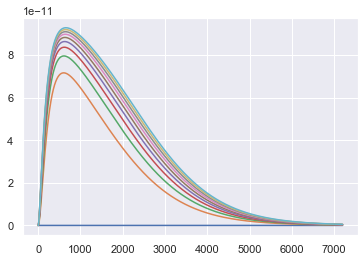

In [112]:
tspan = np.linspace(0, 7200, 72001)

for i in range(0,10,1):
    
       # [R]   [NO] [HNO] [P]  [CoIIIP] [CoIIIPNO] [CoIIPNO] [e]
    y0 = [i*1e-3, 0*1e-3, 0.0,  0.0, 1.2e-9,  0.0,        0.0,     0.0]

    kvals = (2.3e-3, 8e6, 5.6e6)

    electrodo = electrodo_t(tspan, kvals, y0)
    #I = electrodo[:,-1]*96500
    #plt.plot(tspan, no, 'b')
    #plt.plot(tspan, h2s, 'y')
    plt.plot(tspan, electrodo[:,6])
    #plt.plot(tspan[:-1], np.diff(electrodo[:,-1]))

    #plt.legend()
plt.show()

In [100]:
electrodo[:,-1]

array([0.00000000e+00, 5.76437098e-17, 3.23041308e-16, ...,
       1.28263732e-09, 1.28263754e-09, 1.28263776e-09])